<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

# Setup

In [1]:
!nvidia-smi

Thu May 27 12:34:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Select the path for current run images, pay attention, old images in the path will be overwritten!

## Drive mount

In [2]:
if False:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [3]:
# for logging train images
if False:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    #runpath = "/content/drive/MyDrive/progetto_asperti/run2"
    #os.makedirs(runpath)


## Imports

In [4]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D, BatchNormalization


from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

import random 

import os
import gdown
from zipfile import ZipFile #chose this or !unzip

from tqdm.notebook import tqdm

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [5]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Already downloaded")

Already downloaded


Download face attributes hosted on public 
github

In [6]:
USE_LABELS = False
if USE_LABELS:
    !wget -q -O "/content/celeba_gan/list_attr_celeba.txt.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba.txt.zip?raw=true" 
    !unzip "/content/celeba_gan/list_attr_celeba.txt.zip" -d "/content/celeba_gan"

# Keras Dataset 
create Dataset object from our folder, and rescale the images to the [0-1] range:

In [7]:
# image range conversion functions

array255 = np.array([0, 127.5, 255])
array11 = np.array([-1, 0, 1])
array01 = np.array([0, 0.5, 1])

def range255to11(x): return (x / 127.5) -1.0

def range11to255(x): return (x +1-0) * 127.5

def range11to01(x): return (x+1.0) /2.0

def range01to11(x): return x*2.0 -1.0

def range255to01(x): return x / 255.0

def range01to255(x): return x * 255.0

assert np.array_equal(range255to11(array255), array11)
assert np.array_equal(range11to255(array11), array255)
assert np.array_equal(range11to01(array11), array01)
assert np.array_equal(range01to11(array01), array11)
assert np.array_equal(range255to01(array255), array01)

Found 202599 files belonging to 1 classes.


'TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None) in range: 0.0055759805254638195 0.9995098114013672'

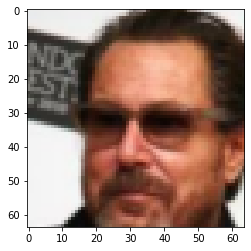

In [8]:
BATCH_SIZE = 16

# load image at exact resolution
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(218, 178), 
    batch_size=BATCH_SIZE)

# dataset_01 and dataset_11 fit images in the (0,1) or (-1,1) range respectively

def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153]# 128,128 center crop

def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True)

dataset_01 = dataset.map(range255to01).map(crop128).map(resize64)
#dataset_11 = dataset.map(range01to11).map(crop128).map(resize64)

test_img = next(iter(dataset_01))[0]

# plt.imshow expects float images to be in (0,1) and int images in (0,255)
plt.imshow((test_img.numpy()))

f"{dataset_01.element_spec} in range: {np.min(test_img)} {np.max(test_img)}"

# Model

## Custom Layers

### Spectral Normalization

In [9]:
from tensorflow.keras import backend as K

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    According to the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        super(SNConv2D, self).__init__(filters, **kwargs)
        self.spectral_normalization = spectral_normalization

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        super(SNConv2DTranspose, self).__init__(**kwargs)
        self.spectral_normalization = spectral_normalization

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

### Pixel Normalization

In [10]:
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate square pixel values
        values = inputs**2.0
        # Calculate the mean pixel values
        mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape
    

### Minibatch Standard Deviation

In [11]:
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

## Define Building Functions

In [12]:
def define_std_discriminator():
    discriminator = keras.Sequential(
    [
        layers.InputLayer(input_shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
    )
    return discriminator

def define_std_generator(latent_dim = 128):

    generator = keras.Sequential(
        [
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8 * 8 * 128),
            layers.Reshape((8, 8, 128)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return generator

discriminator = define_std_discriminator()
generator = define_std_generator()
discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [13]:
# define the standalone discriminator model
def define_discriminator(filters=128, kernel_size=4, strides=(2, 2), in_shape=(64,64,3), in_smooth = True, wgan =False):
    model = keras.Sequential()
    # normal
    #model.add(keras.layers.InputLayer(input_shape = in_shape))
    #model.add(keras.layers.Lambda(lambda x : x + tf.random.normal(shape=in_shape, mean=0.0, stddev=0.01, dtype=tf.float32)))

    model.add(SNConv2D(filters=filters, kernel_size=kernel_size,  strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True, input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 4x4
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(MinibatchStdev())
    model.add(GlobalAveragePooling2D())
    
    # classifier
    model.add(Flatten())
    
    model.add(Dropout(0.4))
    if wgan:
        model.add(Dense(1))
    else:
        model.add(Dense(1), activation='sigmoid')
    # compile model
    #opt = Adam(lr=0.0002, beta_1=0.5)
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, filters=128, kernel_size=4, strides=(2, 2)):
    model = keras.Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 128)))
    
    # upsample to 8x8
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 64x64
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer 64x64x3
    model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='tanh', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    #model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='sigmoid', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    
    return model



## Define GAN Class
override `train_step`

In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs):
        
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


In [15]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}
        
    def call(self, inputs):
      
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss

## Create callbacks

In [16]:
IMAGE_RANGE = '01'

### Images logger

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=128, **kwargs):
        super(GANMonitor, self).__init__(**kwargs)
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)

        generated_images.numpy()
        if IMAGE_RANGE == '11':
            generated_images = range11to01(generated_images)

        if ENABLE_WANDB:
            log_images = [wandb.Image(img) for img in generated_images]
            wandb.log({f"Epoch {epoch}": (log_images)})


"""   def on_batch_end(self, batch, logs=None):

        freq = 2000
        if (batch+1) % freq == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images.numpy()


            fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
            for i, axis in enumerate(axes):
                axis.axis('off')
                if IMAGE_RANGE == '11':
                    axis.imshow(range11to01(generated_images[i]))
                else:
                    axis.imshow(generated_images[i])

            fig.set_facecolor((56/255,56/255,56/255))
            plt.show()
""";

### Model logger

In [19]:
# log checkpoint artifacts to wandb

SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

class WandbLogger(keras.callbacks.Callback):
    def __init__(self, model_name, run):
        super(WandbLogger, self).__init__()
        self.model_name = model_name
        self.run = run
        #self.model = model ########otherwise gan is overwritten at init!
        assert ENABLE_WANDB == True
        
    def on_epoch_end(self, epoch, logs=None):

        self.model.save(SAVE_PATH + self.model_name, save_format='tf')
        self.artifact = wandb.Artifact(self.model_name, type='model')
        self.artifact.add_dir(SAVE_PATH)
        self.run.log_artifact(self.artifact)


### FID Logger

In [20]:
class FIDLogger(keras.callbacks.Callback):
    def __init__(self, real_embeddings):
        super(FIDLogger, self).__init__()
        self.real_embeddings = real_embeddings

    def on_epoch_end(self, epoch, logs=None):

        generator_prep = define_gen_prep(self.model.generator)
        FID_COUNT = 10000
        gen_size = 100
        assert FID_COUNT % gen_size == 0

        generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')

        for i in tqdm(range(FID_COUNT//gen_size)):
            batch_embeddings = generator_prep(tf.random.normal([gen_size, LATENT_DIM]))
            generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

        fid = compute_fid(self.real_embeddings, generated_embeddings)
        print(fid)

        if ENABLE_WANDB:
            wandb.log({'FID': fid})


"""    def on_batch_end(self, batch, logs=None):
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        freq = 200
        if (batch+1) % freq == 0:
            generator_prep = define_gen_prep(self.model.generator)
            FID_COUNT = 10000
            gen_size = 100
            assert FID_COUNT % gen_size == 0

            generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')

            for i in tqdm(range(FID_COUNT//gen_size)):
                batch_embeddings = generator_prep(tf.random.normal([gen_size, LATENT_DIM]))
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

            fid = compute_fid(self.real_embeddings, generated_embeddings)
            print(fid)
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)"""

def define_gen_prep(generator):

    input_noise = tf.keras.layers.Input(shape=[LATENT_DIM], name='noise_input')
    img = generator(input_noise)
    img = tf.cast(img, tf.float32)
    if IMAGE_RANGE == '01':
        img = img*2 -1

    img_up = tf.image.resize(img, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')

    output = inception_model(img_up)

    generator_prep = tf.keras.Model(inputs=[input_noise], outputs=[output])

    return generator_prep

def compute_fid(real_embeddings, generated_embeddings):
    # compute mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # compute sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # compute fid score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [21]:
#fid
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

def define_real_prep():

    img = layers.Input(shape=[64,64,3], name='img_input')
    img_up = tf.image.resize(img, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')
    if IMAGE_RANGE == '01':
        img_up = img_up*2 -1

    output = inception_model(img_up)

    real_prep = tf.keras.Model(inputs=[img], outputs=[output])

    return real_prep

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
real_prep = define_real_prep()

FID_COUNT = 10000
real_batch_size = 100

if IMAGE_RANGE == '01':
    fid_real_loader = dataset_01.unbatch().batch(real_batch_size) 

real_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
for i in tqdm(range(FID_COUNT//real_batch_size)):
    batch_embeddings = real_prep(next(iter(fid_real_loader)))
    real_embeddings[i*real_batch_size:(i+1)*real_batch_size] = batch_embeddings

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible t

# Training

In [22]:

ADAM_LR = 0.0001
ADAM_B1 = 0.9
ADAM_B2 = 0.999
BATCH_SIZE = 16

ENABLE_WANDB = True #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

project_name = "GAN" #@param {type: "string"}
model_name = "chollet" #@param {type: "string"}
experiment_name = "chollet_params" #@param {type: "string"}


assert '-' not in model_name
assert ' ' not in model_name

from keras.callbacks import ModelCheckpoint
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    wandb.config.batch_size = BATCH_SIZE
    wandb.config.adam_lr = ADAM_LR
    wandb.config.adam_b1 = ADAM_B1
    wandb.config.adam_b2 = ADAM_B2
    wandb.notes = "changed input data to (-1,1) to be like the generate tanh one"
    run = wandb.init(project=project_name, name=experiment_name, resume=WANDB_RESUME)


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


## Build the WGAN Model

In [ ]:
if True:
    # Instantiate the optimizer for both networks
    # (learning_rate=0.0002, beta_1=0.5 are recommended)
    generator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9
    )
    discriminator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9
    )

    # Define the loss functions for the discriminator,
    # which should be (fake_loss - real_loss).
    # We will add the gradient penalty later to this loss function.
    def discriminator_loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss


    # Define the loss functions for the generator.
    def generator_loss(fake_img):
        return -tf.reduce_mean(fake_img)

    LATENT_DIM = 128

    discriminator = define_discriminator(wgan=True)
    generator = define_generator(latent_dim = LATENT_DIM)

    # Instantiate the WGAN model.
    wgan = WGAN(
        discriminator=discriminator,
        generator=generator,
        latent_dim=LATENT_DIM,
        discriminator_extra_steps=3,
    )

    # Compile the WGAN model.
    wgan.compile(
        d_optimizer=discriminator_optimizer,
        g_optimizer=generator_optimizer,
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
    )


    # build model for saving
    images, d_loss = wgan.predict(tf.random.normal(shape=(1, LATENT_DIM)))
    plt.imshow(images[0])
    print(images.shape, d_loss)
    wgan.save('models/'+model_name+experiment_name, save_format='tf')


## Build the GAN Model

In [23]:
LATENT_DIM = 128

discriminator = define_std_discriminator()
generator = define_std_generator(latent_dim = LATENT_DIM)

gan = GAN(discriminator, generator, latent_dim = LATENT_DIM)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    g_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    loss_fn=keras.losses.BinaryCrossentropy()#label_smoothing=0.1)
)


# build model for saving
images, d_loss = gan.predict(tf.random.normal(shape=(1, LATENT_DIM)))
print(images.shape, d_loss, np.min(images), np.max(images))
gan.save('models/'+model_name+experiment_name, save_format='tf')

(1, 64, 64, 3) [[0.4936033]] 0.49370542 0.50578517


## Train

In [ ]:
epochs = 70  # In practice, use ~100 epochs

gan.fit(dataset_01, epochs=epochs, 
        #initial_epoch=0, 
        #steps_per_epoch=20,
        callbacks=[
            WandbCallback(log_batch_frequency=10, verbose=1),
            GANMonitor(num_img=8, latent_dim=LATENT_DIM),
            WandbLogger(model_name+experiment_name, run=run),
            FIDLogger(real_embeddings)
            ]
)

Epoch 1/70
12663/12663 [==============================] - 1030s 81ms/step - d_loss: 0.6463 - g_loss: 1.2305


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_94), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_94), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_95), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is pos


733.6231092576099
Epoch 2/70
12663/12663 [==============================] - 1040s 82ms/step - d_loss: 0.6958 - g_loss: 0.8670


wandb: Adding directory to artifact (./models)... Done. 1.8s


The following Variables were used a Lambda layer's call (tf.nn.convolution_188), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_188), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_189), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


529.2734796214343
Epoch 3/70
12663/12663 [==============================] - 1031s 81ms/step - d_loss: 0.7027 - g_loss: 0.8551


wandb: Adding directory to artifact (./models)... Done. 1.8s


The following Variables were used a Lambda layer's call (tf.nn.convolution_282), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_282), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_283), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


533.3795026095773
Epoch 4/70
12663/12663 [==============================] - 1045s 83ms/step - d_loss: 0.7016 - g_loss: 0.8485


wandb: Adding directory to artifact (./models)... Done. 1.4s


The following Variables were used a Lambda layer's call (tf.nn.convolution_376), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_376), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_377), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


638.124618416088
Epoch 5/70
12663/12663 [==============================] - 1043s 82ms/step - d_loss: 0.6921 - g_loss: 0.8721


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_470), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_470), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_471), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


449.3469580571906
Epoch 6/70
12663/12663 [==============================] - 1047s 83ms/step - d_loss: 0.6976 - g_loss: 0.8480


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_564), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_564), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_565), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


605.4343531146543
Epoch 7/70
12663/12663 [==============================] - 1046s 83ms/step - d_loss: 0.7039 - g_loss: 0.8212


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_658), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_658), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_659), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


383.5102632577624
Epoch 8/70
12663/12663 [==============================] - 1048s 83ms/step - d_loss: 0.7055 - g_loss: 0.8133


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_752), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_752), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_753), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


496.1235543700922
Epoch 9/70
12663/12663 [==============================] - 1048s 83ms/step - d_loss: 0.7052 - g_loss: 0.8109


wandb: Adding directory to artifact (./models)... Done. 1.8s


The following Variables were used a Lambda layer's call (tf.nn.convolution_846), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_846), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_847), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


410.29949559877537
Epoch 10/70
12663/12663 [==============================] - 1050s 83ms/step - d_loss: 0.7051 - g_loss: 0.8089


wandb: Adding directory to artifact (./models)... Done. 1.6s


The following Variables were used a Lambda layer's call (tf.nn.convolution_940), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_940), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_941), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is 


522.5796278755047
Epoch 11/70
12663/12663 [==============================] - 1052s 83ms/step - d_loss: 0.7026 - g_loss: 0.8114


wandb: Adding directory to artifact (./models)... Done. 1.7s


The following Variables were used a Lambda layer's call (tf.nn.convolution_1034), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1034), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1035), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It 


597.7598452368376
Epoch 12/70
 8264/12663 [==================>...........] - ETA: 6:06 - d_loss: 0.7062 - g_loss: 0.8058

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
tf.compat.v1.logging.get_verbosity()

In [ ]:
for i in range(19):
  plt.imshow(gan.generator(tf.random.normal(shape=(1, LATENT_DIM)))[0])
  plt.show()

In [ ]:
# load model

artifact = run.use_artifact('buio/GAN/gan_models:v1', type='model')
artifact_dir = artifact.download()

run.join()

print('\n', artifact_dir)
models = os.listdir(artifact_dir)
generators = [model for model in models if 'generator' in model]
discriminators = [model for model in models if 'discriminator' in model]

def run_num(run_name):
    return int(run_name.strip('h5').strip('.').split('_')[-1])

generators.sort(key=run_num)
discriminators.sort(key=run_num)
print(*generators,sep='\n')

In [ ]:
# ri-populate model
generator = tf.keras.models.load_model(artifact_dir+'/'+generators[-1])
discriminator = tf.keras.models.load_model(artifact_dir+'/'+discriminators[-1])

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(dataset, epochs=1, steps_per_epoch=2)


# Losses


In [ ]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1, 0, 0]
y_pred = [0.1, 0.9, 0.1, 0.1]
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.00)
bce(y_true, y_pred).numpy()


In [ ]:
bce([0]*16,discriminator(next(iter(dataset)))[:,0]).numpy()

Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)